# **Disclaimer:**
This assignment must be completed solely by the members of your group. Sharing of code between groups is strictly prohibited. However, you are allowed to discuss general solution approaches or share publicly available resources with members of other groups. Therefore, clearly indicate which public resources you consulted and/or copied code from. Any plagiarism between groups will result in the initiation of a fraud procedure with the director of education.

# **Introduction**

In this assignment, you will train a Reinforcement Learning (RL) agent to address a Residential Energy Management problem.

The goal is for your agent to control a battery and optimize the electricity costs for a residential household. You will submit your trained agent, which will first be evaluated using an evaluation dataset (different from what you have). Following that, your agent will be deployed in a real-world setting: the [HomeLab](https://www.ugent.be/ea/idlab/en/research/research-infrastructure/homelab.htm). After deployment, you will receive data detailing the performance of your agent in both environments. Finally, you will write a brief essay analyzing and discussing the results. \
Moreover, we wrote a set of questions / tasks you can fill in the notebook. Each question will contribute to the final grade you will obtain from this assignment.

The task involves managing energy for a residential household equipped with a Photovoltaic (PV) system and an Energy Storage System (ESS), specifically a battery. In the context of the global shift toward decarbonizing energy sources, these types of challenges are becoming increasingly significant. Reinforcement Learning (RL) has proven to be a promising technique for addressing them.

The setup includes a household where residents consume electricity daily, resulting in a unique consumption profile. Electricity costs are based on a dynamic price profile, with prices varying by the hour. When the household generates more energy (from the PV system or battery) than it consumes, the excess will be sold back to the grid, although the selling price is typically much lower than the buying price.

Your objective is to train an RL agent to control the battery and minimize electricity costs. While this might initially seem straightforward (e.g., charge the battery when prices are low and discharge it when prices are high), there are several challenges that complicate the problem:

*   **Uncertainty in household consumption**: Future consumption is difficult to predict. While models based on inhabitants' habits can provide reasonable estimates[1], there is always a stochastic element involved.
*   **Variability in PV production**: PV energy generation depends on weather conditions, adding another layer of unpredictability.
*   **Dynamic price profiles**: Although, for simplicity, we assume a single price profile repeats daily in this assignment, real-world scenarios often involve prices that vary from day to day.
*   **Physical constraints**: The control of the battery and the accuracy of data from the household (such as PV production and overall consumption) are not perfect. While these issues are ignored in the simulation, they will become evident in the real-world results from HomeLab after your agent has been deployed.

Additionally, although not considered in this assignment, more complex setups may include assets like heat pumps or electric vehicle chargers. These cases may require an extended RL framework, potentially involving multi-agent systems.

In the assignment, you will use an agent based on the [DQN](https://arxiv.org/abs/1312.5602) algorithm. There are some libraries that have already implemented the algorithm, the most famous being [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/#). However, in this assignment, you will write the algorithm code yourself. To help you with the task, we provide you with most of the code you will need to develop a DQN agent.

\

---

\

[1] e.g., by observing that they usually leave for work from 9:00 AM to 18:00 PM and cook at 19:00 PM, we can obtain a sensible model of the expected consumption

\

---

\


Let's now delve into the assignment details!

# **Support Classes**

In this assignment, we provide the essential code to help you train a Deep Q-Network (DQN) agent for a Home Energy Management (HEM) problem. To begin, download the material.zip file available in the course resources. This file contains the necessary code and information to complete the assignment.

After downloading, extract the .py files and upload them into the 'Files' section of this Colab notebook. Next, run the code snippet below, which will import all required external libraries, along with the support classes from the files you just uploaded.

We advise you **not** to change the code we provided you in such files. Any changes in those files that hinder our evaluation of your agents might result in your submission receiving a lower grade.

**N.B:** For training the neural networks used in the DQN algorithm, we require that you use the PyTorch library included in the provided files. Using other deep learning libraries (e.g., TensorFlow) could cause compatibility issues when evaluating your agent.

If you require additional standard Python packages for your work, feel free to import them in the following cell. (by standard Python packages we consider the ones included in the Google colab environment. Avoid using any 'pip install' call in this notebook) \
In case you want to download the notebook and run it locally, you can recreate the colab environment by installing the same versions in your local machine. The list of packages' versions can be seen through the command `!pip freeze` executed below.

In [3]:
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Imports for Neural Networks
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#sys.path.insert(0, 'Environment.py')
#sys.path.insert(0, 'neural_network_support.py')
#sys.path.insert(0, 'data_support.py')

#from neural_network_support import create_mlp_network
#from data_support import Experience, ReplayBuffer
#from Environment import BaseEnvironment


# Extra imports:
# import ...

In [ ]:
!pip freeze

# **Environment**

Now that you imported the classes from the files we provided you, you can start building an RL framework. RL agents learn how to obtain optimal actions by interacting with an environment, modeled by a Markovian Decision Process. The class 'BaseEnvironment' contained in the file 'Environment.py' is exactly that.

Let's initialize a BaseEnvironment class:

First, you need to fix some hyperparameters defining the details of the environment.
- `power_capacity` is the max. power the battery is physically capable of injecting (or withdrawing). It is expressed in kW
- `energy_capacity` is the max. energy the battery is physically allowed to store. It is expressed in kWh

The battery used in the evaluations has a power capacity of 4kW and an energy capacity of 8kWh.

You will also need to load the 'data_dict.pkl' we provided you. The loaded file is a dictionary containing historical data on PV production and household consumption for the weekdays of almost a whole year. Every instance of the `BaseEnvironment` requires as input a data dictionary with the same format we provided you with. \
Further details of the environment are contained in the documentation we provided in the .zip file. **Please read it carefully**

In [4]:
# HYPERPARAMETERS:
power_capacity = 4
energy_capacity = 8

### Environment initialization
with open('data_dict.pkl', 'rb') as f:
    data_dict = pickle.load(f)

env = BaseEnvironment(power_capacity = power_capacity,
                      energy_capacity = energy_capacity,
                      data = data_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'data_dict.pkl'


In machine learning, it is common practice to divide a dataset into at least two parts:

- A training set, used to train the model;
- A validation set, which remains completely unseen by the model during training and is used to assess its performance during and after training.

This division is not always allowed in RL. For example, in board game environments such as chess you do not necessarily have historical data to divide. Hence, in cases like that it is not possible to separate into different sets. However, in problems like this where historical data is available, you can (and should) divide sets to ensure the agent is not simply overfitting on the training set. Below we suggest a possible division that is based on the data available and the conditions in which the agent will be evaluated.

Additionally, the policy of an agent during training often differs from its policy during evaluation. For instance, when evaluating an agent, it may be beneficial to minimize the effect of stochastic events by standardizing evaluation conditions. One way to achieve this is to consistently use the agent's greedy actions during evaluation and ensure that the environment always starts with the same initial states.

In [4]:
train_length = int(len(data_dict) * 0.8)

train_set_indexes = list(range(0, train_length))
test_set_indexes = list(range(train_length, len(data_dict)))

# **DQN Agent**

Now, it is time to start writing the DQN code. In the .zip file, we provided you with some utility classes that will help you train and use a PyTorch neural network. \
Moreover, to help you with the task of implementing a DQN algorithm, we provided you with most of the code structure. \
Below, you can find the class of the DQN agent you will use in the assignment. First, we ask you to **read the code carefully** and understand it as much as possible. The code misses some parts that you will need to fill in. In particular, you need to complete the following methods:
- `_calculate_q_values`: Given a state tensor, it returns the Q values of each action of the fixed action space in the form of an array (or a tensor).
- `act`: Given a state array, it returns the **index** of the action that the agent thinks is the best to apply. \
 **N.B**: The index is linked with the action space, which is fixed. For example, the index `1` refers to the **second** action of the `action_space` array.
- `_calculate_target_Q`: Use the `target_q_network` to obtain the next expected values. These will be used in the standard Bellman equation (that you need to implement) to obtain the target Q-values that will be used to train the `q_network`
- `_training_loop`: We provided you with most of the training loop used by PyTorch. What you will need to do is calculate the Loss values that will be optimized to train the `q_network`. You can use the [MSE Loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) for that.
- `_soft_update_target_network`: It updates the target network's parameters by using a tau parameter, which retains a portion of the previous target weights. This ensures that the target network is not completely overwritten, but instead, a convex linear combination of the previous target and the current Q network is applied. \
When `tau` = 1, the target network is fully updated, becoming identical to the Q network. When `tau` = 0, no updates are applied to the target network.

In [5]:
class DQNAgent:

    def __init__(self,
                 agent_params: dict = None,
                 q_function_params: dict = None,
                 seed: int = 1):

        self.agent_params = agent_params
        self.q_network_params = q_function_params

        # Agent Parameters
        self.buffer_size = self.agent_params['buffer_size']
        self.gamma = self.agent_params['gamma']
        self.tau = self.agent_params['target_update_param']

        self.buffer = ReplayBuffer(self.buffer_size, observation_space=self.q_network_params['input_dim'])

        # Networks
        torch.manual_seed(seed=seed) # Makes experiment replicable
        self._setup_networks()

        # Optimizer
        self.q_network_optimizer = torch.optim.Adam(self.q_network.parameters(),
                                                    lr=self.q_network_params['lr'])

        # Logs (for plotting/analysis purposes)
        self.logs = {
            "q_loss": [],
            "q_values": [],
            "q_values_states": [],
            "action": [],
            "reward": []
        }

    # Calculating Q values for taking each possible action
    def _calculate_q_values(self, tensor_input):
        Q_values = self.q_network(tensor_input)
        return Q_values

    @torch.no_grad()
    def act(self, state: np.ndarray):
        """
        Function to get action value from given state input
        Args:
            state (np.ndarray): State/Observation input -- should be scaled appropriately
        Returns:
            action_index (int): Index of the action from the action_space
        """
        tensor_states = torch.tensor(np.array(state), dtype=torch.float32)

        Q_values = self._calculate_q_values(tensor_states)
        action_index = torch.argmax(Q_values)

        return action_index.item()

    @torch.no_grad()
    def _calculate_target_Q(self, rewards, next_states, dones):
        """
        Returns target Q values (torch.tensor type).
        """
        tensor_next_states = torch.tensor(next_states, dtype=torch.float32)

        # Standard Bellman Computation
        next_Q_values = self.target_q_network(tensor_next_states)
        max_next_Q_values = torch.max(next_Q_values, dim=1)[0].numpy().reshape(len(rewards), 1)
        target_Q = rewards + self.gamma * max_next_Q_values * (1 - dones)
        # returns a matrix where each row contains Q_values for all actions (# rows = # samples in batch) (# columns = # actions)

        tensor_target_Q = torch.tensor(target_Q, dtype=torch.float32)
        return tensor_target_Q

    # Training loop
    def _training_loop(self, states, actions, target_Q):
        tensor_states = torch.tensor(states, dtype=torch.float32)
        training_data = TensorDataset(tensor_states, torch.tensor(actions, dtype=torch.long), target_Q)

        for epoch in range(self.q_network_params["consecutive_grad_steps"]):
            training_dataloader = DataLoader(training_data, batch_size=self.q_network_params["batch_size"])
            for batch in training_dataloader:
                input_state, actions, target = batch

                Q_values = self._calculate_q_values(input_state).gather(1, actions) # select Q_value for each action in batch
                Q_loss = nn.MSELoss()(Q_values, target)

                self.q_network_optimizer.zero_grad()
                Q_loss.backward()
                self.q_network_optimizer.step()

        self.logs["q_loss"].append(float(Q_loss))

    def _soft_update_target_network(self):
        for target_param, param in zip(self.target_q_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def train(self, target_update: bool = False):
        # Step 1-- sample a batch from buffer
        states, actions, rewards, dones, next_states = self.buffer.sample(self.agent_params["buffer_sample"])

        # Step 2-- Train Q
        target_Q = self._calculate_target_Q(next_states=next_states, rewards=rewards, dones=dones)
        self._training_loop(states=states, actions=actions, target_Q=target_Q)

        # Step 3-- Soft update targets
        if target_update:
            self._soft_update_target_network()
            
        # Pick state at hour 5 of day 100 and track learning
        input_state = torch.tensor([-0.58333333, 0.2, -0.70916667, -0.846592, -0.89803295], dtype=torch.float32) 
        self.logs["q_values"].append(self._calculate_q_values(input_state).detach().numpy().flatten())
        self.logs["q_values_states"].append(input_state)
        self.logs["action"].extend([action_space[int(action[0])] for action in actions])

    def add_sample(self, state: np.ndarray, action_index: int | float, reward: float,
                   next_state: np.ndarray, dones: bool) -> None:
        """
        Add a sample of experience to the replay buffer/batch.

        Ensure that actions are integers corresponding to the index of the actual action
        """
        experience = Experience(state=state, action=action_index, reward=reward, done=dones, next_state=next_state)
        self.buffer.add(experience)

    def _setup_networks(self):
        self.q_network = nn.Sequential(*create_mlp_network(input_dim=self.q_network_params['input_dim'],
                                                           output_dim=self.q_network_params['output_dim'],
                                                           network_arch=self.q_network_params['network_arch'],
                                                           activation_fn=self._choose_activation_fn(self.q_network_params['activation_fn']),
                                                           last_layer_init=self.q_network_params["last_layer_init"],
                                                           last_layer_bias=self.q_network_params["last_layer_bias"]
                                                           )
                                       )

        # Create the target network and give it same weight parameters
        self.target_q_network = nn.Sequential(*create_mlp_network(input_dim=self.q_network_params['input_dim'],
                                                                  output_dim=self.q_network_params['output_dim'],
                                                                  network_arch=self.q_network_params['network_arch'],
                                                                  activation_fn=self._choose_activation_fn(self.q_network_params['activation_fn']),
                                                                  last_layer_init=self.q_network_params["last_layer_init"],
                                                                  last_layer_bias=self.q_network_params["last_layer_bias"])
                                              )
        self.target_q_network.load_state_dict(self.q_network.state_dict())

    # ---------------------------------------------------------------------------------------------------------------- #
    # Static helper functions
    @staticmethod
    def _choose_activation_fn(activation_fn: str):
        if activation_fn.lower() == "relu":
            return nn.ReLU
        elif activation_fn.lower() == "tanh":
            return nn.Tanh
        elif activation_fn.lower() == "sigmoid":
            return nn.Sigmoid
        else:
            raise ValueError(f"Incorrect activation function type")


# Save the agent class and its action space
def save_agent(model: DQNAgent, action_space: np.ndarray, path: str = './'):
    with open(path + 'name_file.pkl', "wb") as file:
        pickle.dump(model, file)

    with open(path + 'action_space.pkl', "wb") as file:
        pickle.dump(action_space, file)

# Load the agent class and its action space
def load_agent(path: str = './'):
    with open(path + 'name_file.pkl', "rb") as file:
        model = pickle.load(file)

    with open(path + 'action_space.pkl', "rb") as file:
        action_space = pickle.load(file)

    return model, action_space

# **Interaction agent-environment**

Now that you’ve written the code for the DQN agent, it’s good practice to perform some sanity checks to ensure the agent behaves as expected. But first, we need to implement the code that will serve as the interface between the environment and the agent.

Let’s begin by initializing the agent class. Below is an example of hyperparameters you can use. These values are intentionally chosen to be suboptimal. \
**Keep them as they are for now, but remember to adjust them when you start evaluating the agent's performance.**

In [6]:
# HYPERPARAMETERS:
num_actions = 25

### DQN initialization
agent_params = dict(
    gamma=0.98,                     # Discount factor
    target_update_param=0.001,      # tau
    buffer_size=24*10000,           # ReplayBuffer max capacity
    buffer_sample=256,              # Samples size for each train call
)

q_network_params = dict(
    input_dim=5,                    # Dimension of the environment state. Do not change
    output_dim=num_actions,         # Dimension of the action space.
    network_arch=[128,128],         # The Q-networks are a 2 layers Feed-Forward Neural Networks. These are the number of neurons of the hidden 2 layers.
    activation_fn='tanh',           # Activation functions of the neural networks
    last_layer_init=False,
    last_layer_bias=False,
    lr=0.0001,                      # Learning rate
    consecutive_grad_steps=1,
    batch_size=128,                 # Training batch sizes
)

agent = DQNAgent(agent_params=agent_params,
                 q_function_params=q_network_params)

action_space = np.linspace(-power_capacity, power_capacity, num_actions)

Below is a function that acts as the interface between the agent and the environment. However, the code for selecting actions based on an epsilon-greedy exploration strategy is missing. Complete the function by implementing this part. \
**N.B:** the states and rewards of the environment are **NOT** scaled. Does this hinder the training of the neural networks? How can you fix this?

In [7]:
def environment_episode(epsilon: float = 0, sample_experience: bool = False, day_index: int = 0):
    '''
    Reset and interact with the environment until the end of the selected day.

    epsilon: Exploration / Exploitation factor (epsilon=1 --> pure random actions, epsilon=0 --> action always taken by the agent)
    sample_experience: If True, store the experience in the Replay Buffer of the agent (they will be used for training)
    day_index: Code of the day used in the environment
    '''
    env.reset(day_index)
    total_reward = 0
    while not env.done:
        # Select an action based on a epsilon greedy exploration strategy
        action_index = int(torch.randint(0, num_actions, size=(1,))) if float(torch.rand(size=(1,))) < epsilon else agent.act(env.scale_state(env.state))

        state = env.state
        action = action_space[action_index]
        next_state, reward, done = env.step(action)

        # Sample the experience in the buffer
        if sample_experience:
            agent.add_sample(state=env.scale_state(state),
                             action_index=action_index,
                             reward=env.scale_reward(reward),
                             next_state=env.scale_state(next_state),
                             dones=done)
        total_reward += reward

    return total_reward

# **Training loop**

Finally, we are ready to train and evaluate the agents. Below we provide you with a possible loop you can use to do so. This has to be intended as a starting point. As you experiment with this assignment, think of how you can improve the training based on the knowledge you learned in the classes.

In [8]:
rewards = []
epsilons = []
decay_rate = 0.9998
evaluate_rewards = []

def rl_training_loop(starting_epsilon: int = 1, num_episodes: int = 100):
    """
    This function should represent the DQN algorithm (slide 22).
    We train a specific day (100) a certain amount of times (num_episodes).
    First we simply interact with the environment to get the total reward,
    next we train the agent (this happens independent from interaction with environment before,
    it simply redos the thing).
    """
    epsilon = starting_epsilon
    rewards.clear()
    epsilons.clear()
    print("decay_rate", decay_rate)
    print("agent_params: ", agent_params)
    print("q_network_params: ", q_network_params)
    C = 1
    for episode in range(num_episodes):
        day_index = np.random.choice(train_set_indexes)
        reward = environment_episode(epsilon=epsilon, sample_experience=True, day_index=day_index)
        rewards.append(reward)
        # Check the method input parameters. Can you do something with them?
        agent.train(target_update=(episode % C == 0) if episode > 0 else False)
    
        # Update epsilon. How can you gradually reduce epsilon?
        minimum_epsilon = 0.01
        epsilon = max(minimum_epsilon, decay_rate*epsilon)
        epsilons.append(epsilon)
    
        if episode % 200 == 0:
            evaluate_rewards.append(evaluate_agent())
            
        if (100 * (episode / num_episodes)) % 1 == 0:
            print(f"{episode}/{num_episodes} ({100 * (episode / num_episodes)} %) reward: {reward}, epsilon: {epsilon}, loss: {agent.logs['q_loss'][-1]}, evaluate reward: {evaluate_rewards[-1]:.3f}")
            
def evaluate_agent():
    rewards = []
    for day_index in test_set_indexes:
        reward = environment_episode(epsilon=0, sample_experience=False, day_index=day_index)
        rewards.append(reward)
    return np.average(rewards)

# **Conclusions**

Now you have everything you need to start training an effective agent.

To proceed further, you can change the hyperparameters, write new functions to keep track of the training process, and produce informative graphs that can help you understand what is going on behind the curtains of the model. \
To double check the code you just wrote, try to train and evaluate the agent on a single day (i.e., using the same data of 1 single day for both training and evaluation). This is a very simple task, hence your agent is supposed to behave optimally without too many difficulties. For example, try with day number 100. Your agent should be able to achieve a daily total reward that is at least greater than -0.4 (when using a 4kW, 8kWh battery). \
**Your final agent and the action space need to be saved using the methods we provided you. The agent you will upload will be evaluated on a private dataset taken out of the data we gave you, and the results will influence the score of your assignment.**

Whatever extra code you think you will need to train the agent, please write it below. \
**Moreover, we prepared a set of questions and tasks for you. These are part of your assignment evaluation.**

In [9]:
rl_training_loop(starting_epsilon=1, num_episodes=100000)

decay_rate 0.9998
agent_params:  {'gamma': 0.98, 'target_update_param': 0.001, 'buffer_size': 240000, 'buffer_sample': 256}
q_network_params:  {'input_dim': 5, 'output_dim': 25, 'network_arch': [128, 128], 'activation_fn': 'tanh', 'last_layer_init': False, 'last_layer_bias': False, 'lr': 0.0001, 'consecutive_grad_steps': 1, 'batch_size': 128}
0/100000 (0.0 %) reward: -1.3845394096723247, epsilon: 0.9998, loss: 2.625387191772461, evaluate reward: -2.158
1000/100000 (1.0 %) reward: -0.9684687222093229, epsilon: 0.8185506335678283, loss: 0.08900779485702515, evaluate reward: -2.141
2000/100000 (2.0 %) reward: -1.26214685123553, epsilon: 0.6701591715486028, loss: 0.025844644755125046, evaluate reward: -2.141
3000/100000 (3.0 %) reward: -2.418135482095799, epsilon: 0.5486689482520511, loss: 0.01688893884420395, evaluate reward: -1.471
4000/100000 (4.0 %) reward: -0.490722787718843, epsilon: 0.44920315584187787, loss: 0.01666712760925293, evaluate reward: -1.489
5000/100000 (5.0 %) reward: -

In [10]:
environment_episode(epsilon=0, sample_experience=False, day_index=100)

np.float64(-0.27241573986250117)

In [11]:
evaluate_agent()

np.float64(-1.1905853067584413)

In [12]:
save_agent(agent, action_space, f"./agent-{np.random.randint(1000000, 9999999)}")

### **Question 1**
Coming out with good hyperparameters is not straightforward. Can you make a list below of the most important hyperparameters you had to choose to obtain better results? Give brief intuitions for each. If needed, you can back it up with evaluation results.

- `num_actions`: When the number of actions is high, it takes the agent more episodes to understand the influence of each individual action. If the number of actions is too low, the agent will not be able to make decisions with enough precision. We believe that a precision of 0.33 kWh is fine for this application (this is the case when we pick `25` actions).
- `buffer_size`: A small buffer narrows the experience window of the agent. For example, when the buffer can only hold data of 7 days, it will only keep track of the last 7 episodes (in the case 1 episode equals 1 day) and essentially forget anything else it has learned before. We considered catastrophic forgetting, where the agent forgets earlier actions, and especially those that it should not do (e.g. during the exploration phase). That's why buffer sizes are typically very large. To train, we keep about `10000` episodes/days into memory.
- `buffer_sample`: Whenever the `train()` function is called (i.e. every episode), a set of samples is selected at random from the experience buffer. These samples are used in a single `_training_loop()`. If we pick this set of samples too small, the network will only have limited data to base its parameter update on. However, with increasing amount of samples, the number of computations increases (and hence, it takes longer to train the agent). A nice trade-off in our case was `256`.
- `gamma`: This parameter determines how much future rewards are valued compared to immediate rewards. Chosing this parameter high (close to one) will encourage the agent to focus on the long-term, while a low value of gamma will have the agent focus on the short-term. In this situation, we obviously want the agent to optimize costs over the entire year, and not just over the current hour. Hence, we choose gamma to be `0.98`, which is high.
- `target_update_param`: This parameter controls how fast the target network should approximate the Q network. Typically, we want this parameter to be low such that the target network appears stable and does not oscillate with the policy. If we would pick tau high, then the target (Q value) is essentially chasing its own tail! Here, we want the target network and Q network to gradually get closer to each other. A value of `0.001` seemed to work well in our experiments. We also experimented with only performing the soft-update every `C` iterations, which allows for a higher value of tau.
- `lr`: The higher the learning rate, the larger the updates that are made to the network. This can cause the model to skip optima (overshooting). In general a learning rate of 10 is way too high to be able to train a neural network; and this definitely did not perform well here. So, we've opted for a small learning rate of `0.0001`, which provides more refined updates (slower convergence).
- `batch_size`: From each buffer sample, `batch_size` samples are selected. The samples from each batch propagate through the neural network sequentially. Once an entire batch is processed, we update all weights of the Q network (using backpropagation). When the batch size is large, the computed gradients are based on more diverse samples (which reduces variance). When the batch size is small, the agent will oscillate between policies more often (because each update is based on fewer samples and those samples may be correlated). We've selected a batch size of `128`, so gradients are averaged out over `128` samples.
- `network_arch`: It turns out that for this simple problem, the network architecture should not be too big. When training on day 100, an architecture of `[128, 128]` seemed to perform well. Larger networks overfit more easily, and are a lot more sensitive.

### **Question 2:**
When training an RL agent (or whatever Machine Learning model), a crucial step is to track the learning. Can you produce some informative graphs that tells you how is the training going? What observation can you draw from those? \
**N.B:** This will require some changes in the DQNAgent class. Make sure that the `act` method structure (take a state as input, return an action index as output) is not changed as that will be the method we will need to use for our evaluation.

Briefly explain what you did and why here:

To track the training procedure, we made three charts.
1. **Evolution of Q loss with experience** — This chart gives us an idea of whether the Q values are approaching our target (i.e. whether learning is converging). For each call to `agent.train()`, we keep track of the Q loss for that single iteration (one Q loss per episode; the last one after all batches were processed). As we progress through episodes, the Q loss reduces, i.e. the Q values are getting closer to the target values. We obviously do not want this to happen too fast, as that may yield a local optimum. As you can see from the graphs, during exploration the Q loss is high, and gradually decreases.
2. **Evolution of total reward with experience** — This chart gives us an idea of the performance of the agent over episodes. For each episode, we keep track of the total reward obtained for that episode given the current Q network. With training, this total reward should increase. Every `n` episodes, we also validate our current Q network using `evaluate_agent()`. Ideally, the test results should converge to the training results. Looking at the charts, we see that there remains a gap between training and test results. We only trained the agent on part of the year, which is not sufficient to obtain accurate results over an entire year (e.g. seasons matter).
3. **Evolution of epsilon with experience** — This chart gives us an idea of whether the agent is exploring or exploiting. We decrease the value of epsilon (exploration parameter) as we progress through the episodes. At the start, we allow the agent to explore random actions, but as time goes on exploration is replaced by exploitation. Also here, epsilon may not decrease too fast, but also not too slow. Note that in our code, we've selected a minimum epsilon of `0.01`, so there always is a slight chance for the agent to explore.

In [13]:
def subsample(data, factor=200):
    trimmed_length = (len(data) // factor) * factor
    trimmed_data = np.array(data[:trimmed_length])
    return np.mean(trimmed_data.reshape(-1, factor), axis=1)

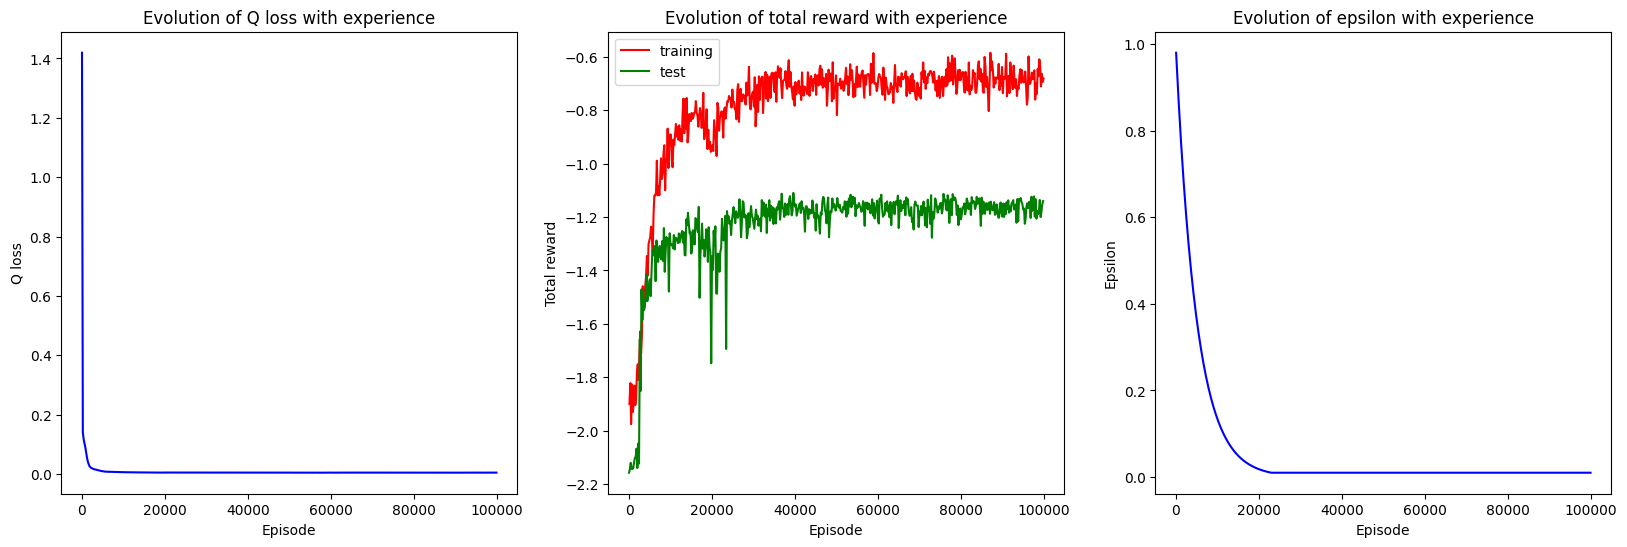

In [14]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(subsample(range(len(agent.logs["q_loss"]))), subsample(agent.logs["q_loss"]), color="blue")
plt.title("Evolution of Q loss with experience")
plt.xlabel("Episode")
plt.ylabel("Q loss")

plt.subplot(1, 3, 2)
plt.plot(subsample(range(len(rewards))), subsample(rewards), color="red", label="training")
plt.plot([i*200 for i in range(len(evaluate_rewards))], evaluate_rewards, color="green", label="test")
plt.title("Evolution of total reward with experience")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(subsample(range(len(epsilons))), subsample(epsilons), color="blue")
plt.title("Evolution of epsilon with experience")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()

### **Question 3:**

When using RL on a given problem, **you** also need to understand what the problem is about. Following that, it is important to keep track of the agent's performance by not only checking its numerical metrics (e.g., the obtained daily rewards), but also by checking if its actions make sense in the first place. To do so, plotting the policies obtained on a limited interval of time (e.g., a single day) is crucial. Can you write a function that does that? What observations / conclusions can you draw when you plot the agent policies?  

Briefly explain your observations here:

The plots below showcase the behavior of the agent as well as the price fluctuations on day 100. Note that, to better visualize the reward, we have multiplied the rewards by 20. The reward indicates the cost of energy consumed at that hour. Whenever the agent is discharging, the reward is positive (unless there is not enough energy stored, in that case we still need to buy); whenever the agent is charging, the reward is negative (but less so when we also have energy that is being generated).

It is apparent that the agent has learned to charge the battery (positive action) when prices are low. When prices are high on the other hand, the agent prefers to discharge the battery (negative action). The agent also learned to anticipate future consumption. Prior to large consumption peeks, the agent has been performing charge operations (buying or storing energy, typically at low prices).

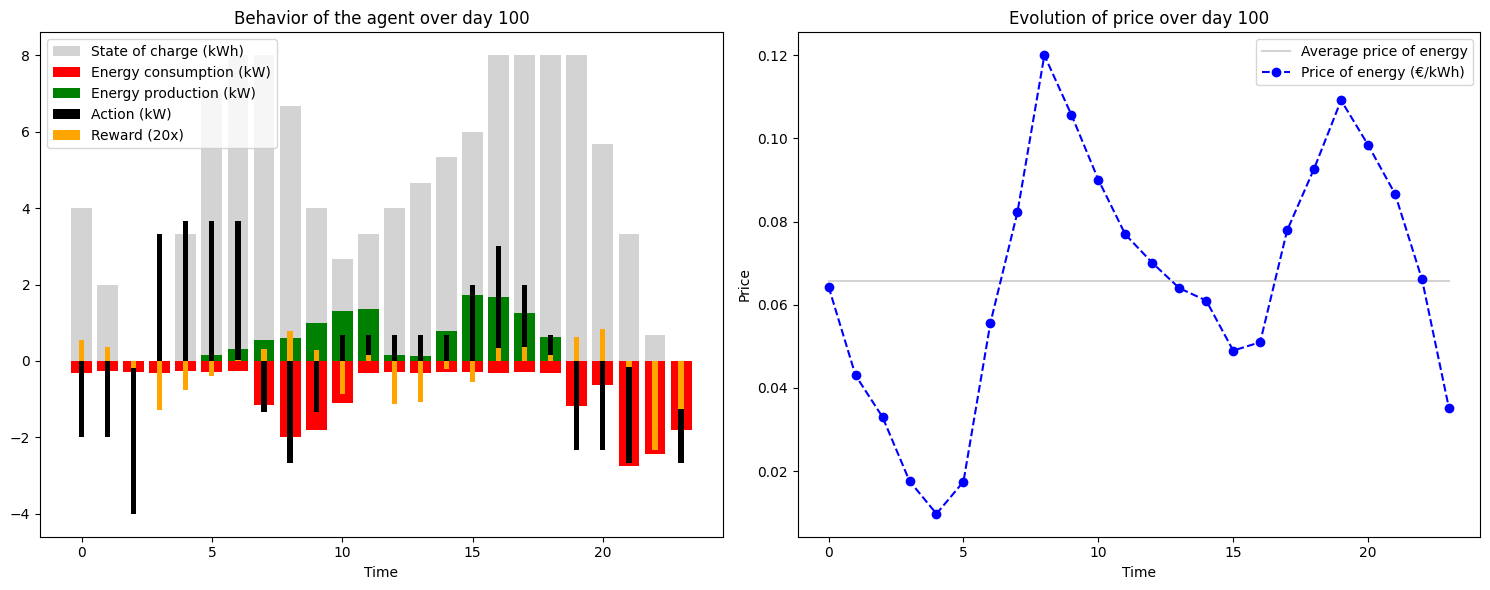

-0.27241573986250117


In [15]:
# Policy graphs
def plot_agent_policy(agent, day_index: int = 0, epsilon: float = 0):
    env.reset(day_index)
    states, actions, rewards = [], [], []

    while not env.done:
        state = env.state
        states.append(state)

        action_index = int(torch.randint(0, num_actions, size=(1,))) if float(torch.rand(size=(1,))) < epsilon else agent.act(env.scale_state(env.state))
        action = action_space[action_index]
        actions.append(action)

        next_state, reward, done = env.step(action)
        rewards.append(reward)

    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.bar(np.arange(24), states[:,1] * energy_capacity, label="State of charge (kWh)", color="lightgray")
    plt.bar(np.arange(24), -states[:,4], label="Energy consumption (kW)", color="red")
    plt.bar(np.arange(24), states[:,3], label="Energy production (kW)", color="green")
    plt.bar(np.arange(24), actions, label="Action (kW)", color="black", width=.2)
    plt.bar(np.arange(24), 20*rewards, label="Reward (20x)", color="orange", width=.2)
    plt.title(f"Behavior of the agent over day {day_index}")
    plt.xlabel("Time")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(24), np.ones(24)*np.average(states[:,2]), color="lightgray", label="Average price of energy")
    plt.plot(np.arange(24), states[:,2], label="Price of energy (€/kWh)", color="blue", marker="o", linestyle="--")
    plt.title(f"Evolution of price over day {day_index}")
    plt.ylabel("Price")
    plt.xlabel("Time")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(np.sum(rewards))

plot_agent_policy(agent, day_index=100, epsilon=0)

### **Question 4:**

One of the benefits of implementing an algorithm from scratch (besides the obvious one of understanding more deeply what the algorithm is about) is the total control over the code you just wrote. This enables you to customize your code to, for example, gain informative insights regarding the algorithm dynamics. Can you think of some experiments you can run to get insightful graphs / information about the agent? For example, how can you check if the Q-values are being correctly learned?

Briefly explain what you did and why:

In order to check whether Q values are being learned correctly, we choose a certain state (e.g. state at 5 o'clock on day 100) and track the Q values over time. From a human perspective, we know that at 5 o'clock:
* energy is likely to be cheap (because nobody is awake yet)
* the battery is likely to be empty (because there has been no sun during the night)
* we will soon use energy (because we need to prepare breakfast or turn on the lights)

It is reasonable to assume that an optimal choice for the agent would be to buy energy at 5 o'clock (whatever time of the year). 

The agent was modified to take keep track of the Q values of the state at 5 o'clock on day 100. Below, we've plotted the evolution of these Q values over time. Remember that the action with the highest Q value is selected by the agent, hence red regions are more likely to be selected. It is clear that as time progresses, there is a shift in Q values from negative actions (discharge) to positive actions (charge). Our agent is in fact learning to buy energy at 5 o'clock.

In [16]:
def plot_q_values(from_update, to_update):
    q_values = np.array(agent.logs["q_values"])[from_update:to_update]
    if len(q_values) > 0:
        plt.figure(figsize=(18,8))
        plt.imshow(np.transpose(q_values), aspect="auto", cmap="coolwarm", extent=[from_update, to_update, power_capacity, -power_capacity,])
        plt.colorbar()
        plt.ylabel("Actions")
        plt.xlabel("Episode")
        state = [round(float(x), 3) for x in env.descale_state(agent.logs['q_values_states'][0])]
        plt.title(f"Evolution of Q values over time for state {state}")
        plt.show()

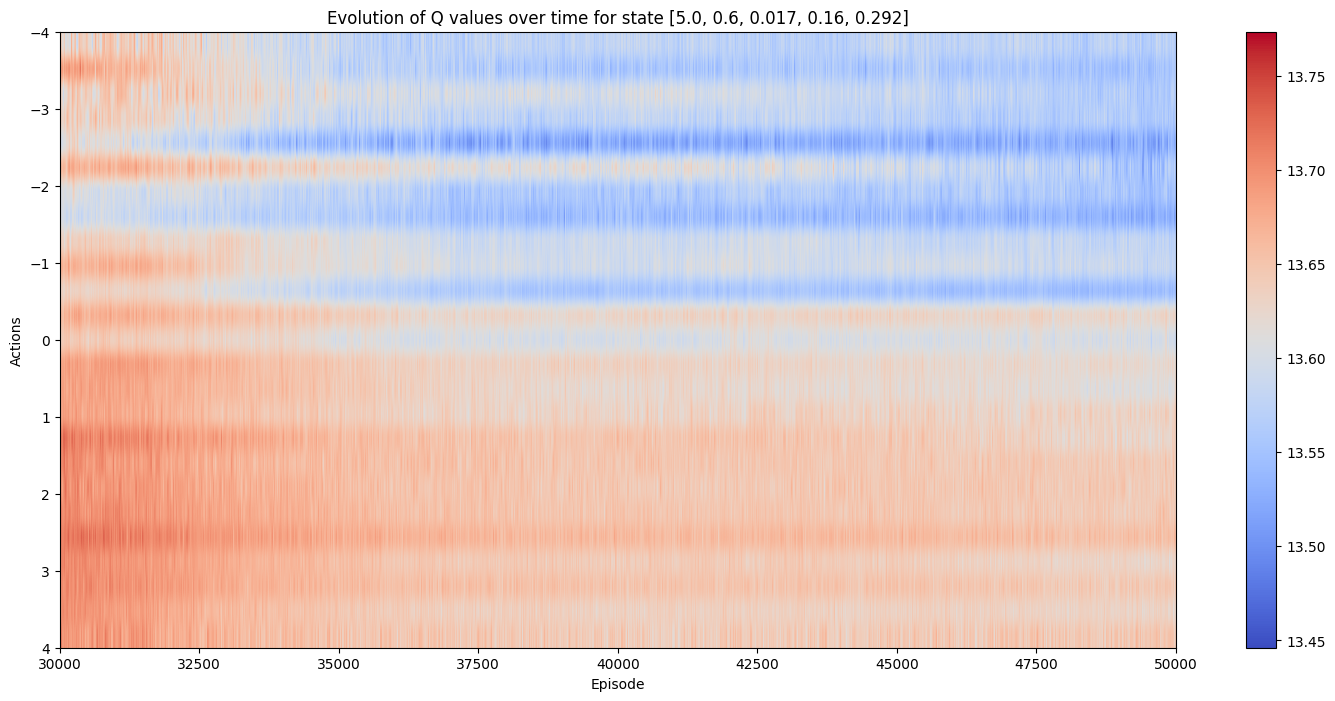

In [17]:
plot_q_values(50000-20000, 50000)

At the end of the training procedure, the agent clearly prefers charging the battery in the early morning.

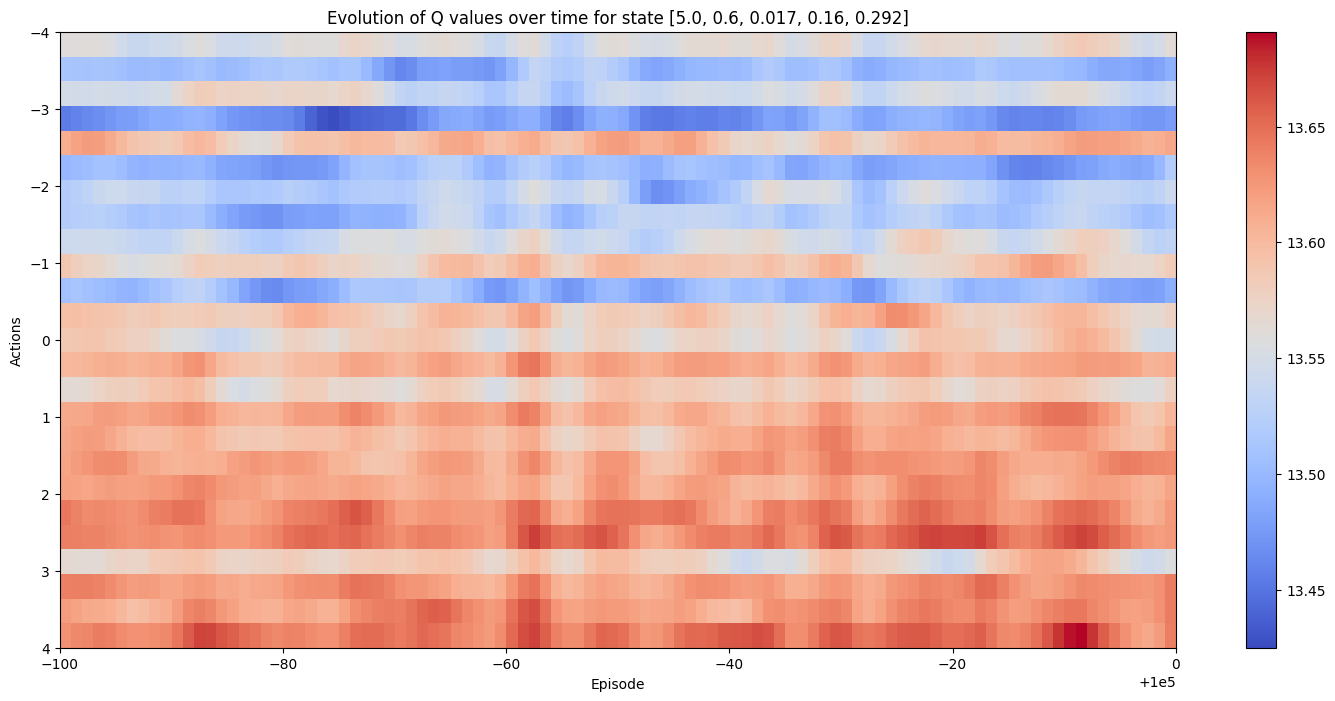

In [18]:
plot_q_values(100000-100, 100000)